In [1]:
%matplotlib inline

In [49]:
import xarray as xr
from datatree import DataTree
from pathlib import Path
import pandas as pd
from dask.diagnostics import ProgressBar
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import cartopy.crs as ccrs
import valenspy as vp
from valenspy.diagnostic.visualizations import _add_features
from valenspy.diagnostic.functions import root_mean_square_error

git_dir = Path(os.popen("git rev-parse --show-toplevel").read().strip())

User options

In [56]:
# Load data options
variables = ["tas", "pr", "tasmin", "tasmax"]
period = [1980, 2019]

# Plotting options - to be moved to a seperate "config" file
## Use the seaborn-v0_8-deep style?

mpl.rc('axes',edgecolor='grey')
mpl.rc('axes',labelcolor='dimgrey')
mpl.rc('axes',titlesize=14)
mpl.rc('axes',labelsize=10)
mpl.rc('axes', titlelocation="right")
mpl.rc('xtick',color='dimgrey')
mpl.rc('xtick',labelsize=10)

mpl.rc('ytick',color='dimgrey')
mpl.rc('ytick',labelsize=10)

mpl.rc('legend',fontsize='large')
mpl.rc('legend',fancybox=False)

mpl.rc('text',color='dimgrey')


## Specify colors for the specific models
color_dict = {
    "/RCM/ERA5/ALARO1_SFX"          : "blue",
    "/RCM/ERA5/CCLM6-0-1-URB-ESG"   : "red",
    "/RCM/ERA5/MAR"                 : "green",
    "/obs/CLIMATE_GRID"             : "black"
}

d_cmap_diverging = { "tas": 'RdBu_r', "tasmax":'RdBu_r', "tasmin":'RdBu_r', "pr": 'BrBG' }

# Diagnostic switches

## Model2Self
AnnualCycle = True
TimeSeries = True
TimeSeriesUkkel = True
Trends = True
SpatialBias = True
SpatialMean = True

#Add iteration over the variables that we would like to be plotted.
#Add color maps per diagnostic
#Add option for season

STEP 1: Load the data

In [4]:
manager = vp.InputManager(machine="hortense")

# ALARO (Using the catalog and the variables userinput)

df_alaro = pd.read_csv("/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/ValEnsPy/CORDEX_eval_scripts/catalog.csv")
df_alaro = df_alaro[df_alaro['frequency'] == 'day']
df_alaro = df_alaro[df_alaro['variable_id'].isin(variables)]
df_alaro

#Load all the paths in the df into one xarray dataset
ds_alaro = xr.open_mfdataset(df_alaro['path'].values, decode_coords='all', chunks="auto")
ds_alaro

## (Requires user adjustment)
# COSMO (Using the input manager - currently variables loaded manually)
experiment      = "CB2_CCLM_BEL28_ERA5_evaluation"
ds_cclm_tas     = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "mean"])
ds_cclm_tasmax  = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "max"]).rename({'tas':'tasmax'})
ds_cclm_tasmin  = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "min"]).rename({'tas':'tasmin'})
ds_cclm_pr      = manager.load_data("CCLM", ["pr"], freq="daily", path_identifiers=[experiment, "sum"])
ds_cclm         = xr.merge([ds_cclm_tas, ds_cclm_pr, ds_cclm_tasmax, ds_cclm_tasmin])
del ds_cclm_tas, ds_cclm_pr, ds_cclm_tasmax, ds_cclm_tasmin

## (Requires user adjustment)
# MAR (Placeholder for MAR data - for plotting purposes)
ds_mar = ds_alaro

# Observational data
## CLIMATE_GRID (Regridded data)

ds_ref = manager.load_data("CLIMATE_GRID", variables, path_identifiers=["regridded"])

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2014.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2019.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2018.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1990.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2008.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2020.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/dail

Create a DataTree object

In [5]:
## (Requires user adjustment)
data_dict = {
    "RCM/ERA5/ALARO1_SFX": ds_alaro,
    "RCM/ERA5/CCLM6-0-1-URB-ESG": ds_cclm,
    "RCM/ERA5/MAR": ds_mar,
    "obs/CLIMATE_GRID": ds_ref
}

dt = DataTree.from_dict(data_dict)

STEP 2: Preprocessing the data

In [6]:
#Regid to CLIMATE_GRID
dt["RCM"] = dt["RCM"].map_over_subtree(vp.remap_xesmf, dt.obs.CLIMATE_GRID.to_dataset(), method="conservative", regridding_kwargs={"keep_attrs": True})

#Select the time period from period[0] to period[1] (inclusive)
dt = dt.sel(time=slice(f"{period[0]}-01-01", f"{period[1]}-12-31"))

STEP 3: Diagnostics

Model2Self

Annual Cycle

In [57]:
if AnnualCycle:
    from valenspy.diagnostic import AnnualCycle
    with ProgressBar():
        dt_annual_cycle = dt.map_over_subtree(AnnualCycle)
        dt_annual_cycle = dt_annual_cycle.compute()

[########################################] | 100% Completed | 104.20 s
[########################################] | 100% Completed | 28.13 s
[########################################] | 100% Completed | 97.84 s
[########################################] | 100% Completed | 12.42 s


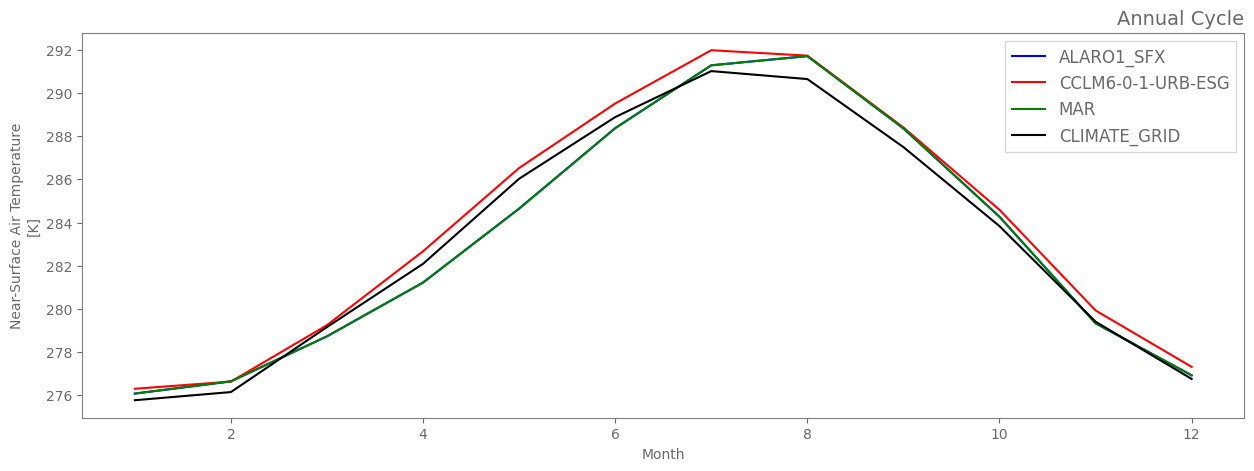

In [58]:
if AnnualCycle:
    fig, ax = plt.subplots(figsize=(15, 5))
    for leaf in dt_annual_cycle.leaves:
        AnnualCycle.plot(leaf["tas"], ax=ax, label=leaf.name, color=color_dict[leaf.path])
    plt.legend()
    plt.savefig(git_dir / "CORDEX_eval_scripts/plots/Bel_mean_annual_cycle.png")

TimeSeries

In [63]:
if TimeSeries:
    from valenspy.diagnostic import TimeSeriesSpatialMean
    heat_wave=["1997-06-01", "1997-08-31"]
    with ProgressBar():
        dt_time_series = dt.sel(time=slice(heat_wave[0], heat_wave[1]))
        dt_time_series = dt.map_over_subtree(TimeSeriesSpatialMean)
        dt_time_series = dt_time_series.compute()

[########################################] | 100% Completed | 65.33 s
[########################################] | 100% Completed | 28.64 s
[########################################] | 100% Completed | 70.82 s
[########################################] | 100% Completed | 8.97 ss


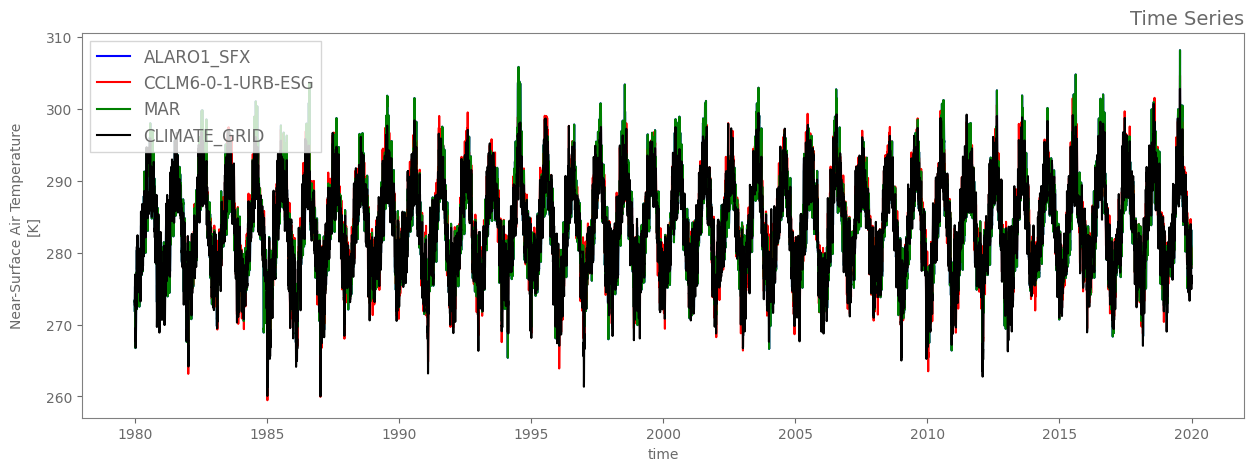

In [64]:
if TimeSeries:    
    fig, ax = plt.subplots(figsize=(15, 5))
    for leaf in dt_time_series.leaves:
        TimeSeriesSpatialMean.plot(leaf["tas"], ax=ax, label=leaf.name, color=color_dict[leaf.path])
    plt.legend()
    plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/Bel_mean__time_series_{heat_wave[0]}_{heat_wave[1]}.png")

TimeSeries (Ukkel)

In [66]:
if TimeSeriesUkkel:
    from valenspy.diagnostic import TimeSeriesSpatialMean
    Ukkel = (4.37, 50.79)
    heat_wave=["1997-06-01", "1997-08-31"]
    with ProgressBar():
        dt_time_series_uccle = dt.map_over_subtree(vp.select_point, Ukkel[0], Ukkel[1]).map_over_subtree(TimeSeriesSpatialMean)
        dt_time_series_uccle = dt_time_series_uccle.compute()

[########################################] | 100% Completed | 62.41 s
[########################################] | 100% Completed | 27.69 s
[########################################] | 100% Completed | 72.34 s
[########################################] | 100% Completed | 3.08 sms


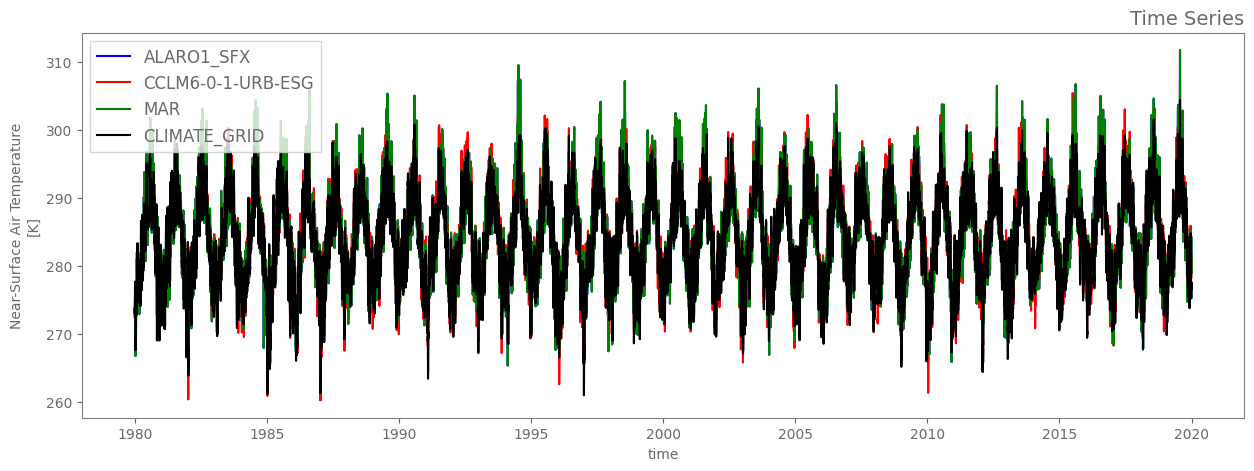

In [67]:
if TimeSeriesUkkel:
    fig, ax = plt.subplots(figsize=(15, 5))
    for leaf in dt_time_series_uccle.leaves:
        TimeSeriesSpatialMean.plot(leaf["tas"], ax=ax, label=leaf.name, color=color_dict[leaf.path])
    plt.legend()
    plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/Uccle_time_series_{heat_wave[0]}_{heat_wave[1]}.png")


Trends

In [68]:
if Trends:
    from valenspy.diagnostic import TimeSeriesTrendsSpatialMean
    Ukkel = (4.37, 50.79)
    dt_Ukkel = dt.map_over_subtree(vp.select_point, Ukkel[0], Ukkel[1])
    dt_Ukkel = dt_Ukkel - dt_Ukkel.sel(time=slice("1980-01-01", "1985-12-31")).mean("time")
    with ProgressBar():
        dt_trends = dt.map_over_subtree(TimeSeriesTrendsSpatialMean)
        dt_trends = dt_trends.compute()

ImportError: cannot import name 'TimeSeriesTrendsSpatialMean' from 'valenspy.diagnostic' (/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/ValEnsPy/src/valenspy/diagnostic/__init__.py)

In [15]:
if Trends:
    fig, ax = plt.subplots(figsize=(15, 5))
    for leaf in dt_trends.leaves:
        TimeSeriesTrendsSpatialMean.plot(leaf["tas"], ax=ax, label=leaf.name, color=color_dict[leaf.path])
    plt.legend()
    plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/Uccle_time_series_trend_normalized.png")

Model2Ref

SpatialBias

In [19]:
if SpatialBias:
    var="tas"
    from valenspy.diagnostic import SpatialBias
    with ProgressBar():
        ds_ref = dt.obs.CLIMATE_GRID.to_dataset()
        dt_spatial_bias = dt.RCM.map_over_subtree(SpatialBias, ref=ds_ref)
        dt_spatial_bias = dt_spatial_bias.compute()

[########################################] | 100% Completed | 105.35 s
[########################################] | 100% Completed | 34.06 s
[########################################] | 100% Completed | 84.54 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_en

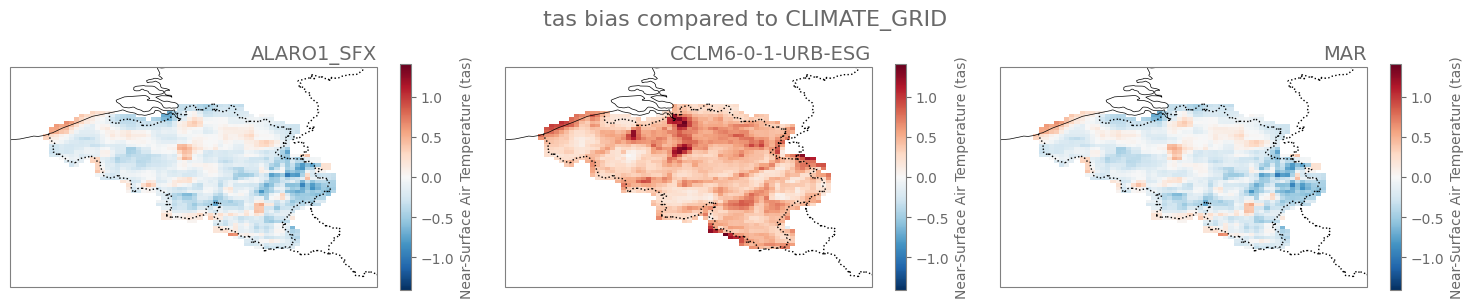

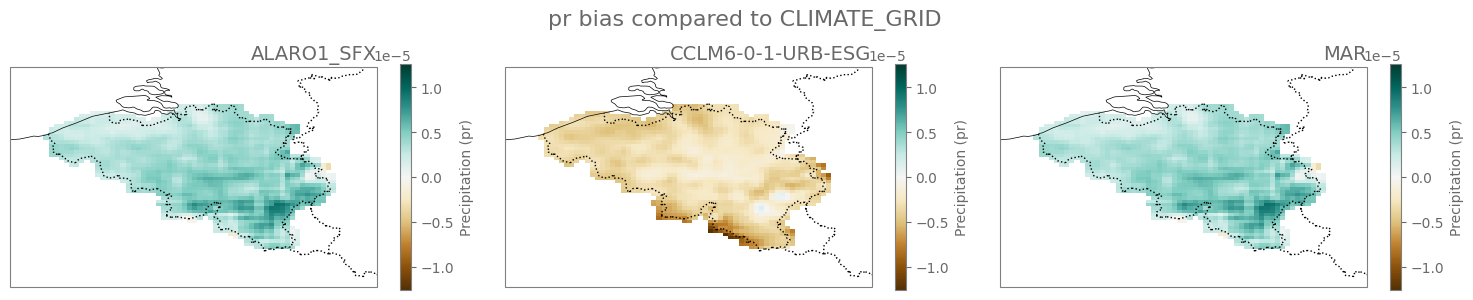

In [62]:
if SpatialBias:
    for var in variables:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})
        axes = axes.flatten()
        cbar_kwargs={"shrink": 0.52}

        min = np.max([dt[var].values for dt in dt_spatial_bias.max().leaves])
        max = np.min([dt[var].values for dt in dt_spatial_bias.min().leaves])

        v_value = np.max([np.abs(min), np.abs(max)])

        for ax, dt_leave in zip(axes, dt_spatial_bias.leaves):
            SpatialBias.plot(dt_leave[var], ax=ax, cmap=d_cmap_diverging[var], cbar_kwargs=cbar_kwargs, vmin=-v_value, vmax=v_value)
            ax.set_title(dt_leave.name)
            #ax.set_title(' ')
            _add_features(ax, region='belgium')

        fig.suptitle(f'{var} bias compared to CLIMATE_GRID', fontsize=16, y=0.8)
        fig.tight_layout()
        plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/spatialbias_{var}.png")

In [ ]:
  
## SpatialMean
if SpatialMean:
    d_cmap_sequential = {
    "tas": 'YlOrRd',
    "tasmax": 'YlOrRd',
    "tasmin": 'YlOrRd',
    "pr": 'YlGnBu' }
    with ProgressBar():
        dt_spatial_mean = dt.mean(dim="time")
        dt_spatial_mean = dt_spatial_mean.compute()

    #User input (size of the plots)
    fig, axes = plt.subplots(2,2,figsize=(9,5), subplot_kw={"projection": ccrs.PlateCarree()})
    axes = axes.flatten()

    # get overall min and max
    overall_min, overall_max = get_dt_overall_min_max(dt_timmean, variable)

    # loop over datasets to do plotting
    for i, dt_leave in enumerate(dt_timmean.leaves):
        ax = axes[i]
        ds = dt_leave.to_dataset()
        ds[variable].plot(ax=ax, cmap=d_cmap_sequential[variable], vmin=overall_min, vmax=overall_max)
        ax.set_title(dt_leave.name, loc='right')
        ax.set_title(' ')
        _add_features(ax, region='belgium')

    fig.suptitle(f'{ds[variable].long_name} ({ds[variable].units})', fontsize=16)

    fig.tight_layout()
    # Mean maps
    plt.savefig(f"/dodrio/scratch/users/vsc31332/rmi/vsc31332_inne/ValEnsPy/CORDEX_eval_scripts/plots/timmean_{variable}_{averaging_period}.png")


In [ ]:
## SpatialMean
if SpatialMean:
    d_cmap_sequential = {
    "tas": 'YlOrRd',
    "tasmax": 'YlOrRd',
    "tasmin": 'YlOrRd',
    "pr": 'YlGnBu' }
    with ProgressBar():
        dt_spatial_mean = dt.mean(dim="time")
        dt_spatial_mean = dt_spatial_mean.compute()

    #User input (size of the plots)
    fig, axes = plt.subplots(2,2,figsize=(9,5), subplot_kw={"projection": ccrs.PlateCarree()})
    axes = axes.flatten()

    # get overall min and max
    overall_min, overall_max = get_dt_overall_min_max(dt_timmean, variable)

    # loop over datasets to do plotting
    for i, dt_leave in enumerate(dt_timmean.leaves):
        ax = axes[i]
        ds = dt_leave.to_dataset()
        ds[variable].plot(ax=ax, cmap=d_cmap_sequential[variable], vmin=overall_min, vmax=overall_max)
        ax.set_title(dt_leave.name, loc='right')
        ax.set_title(' ')
        _add_features(ax, region='belgium')

    fig.suptitle(f'{ds[variable].long_name} ({ds[variable].units})', fontsize=16)

    fig.tight_layout()
    # Mean maps
    plt.savefig(f"/dodrio/scratch/users/vsc31332/rmi/vsc31332_inne/ValEnsPy/CORDEX_eval_scripts/plots/timmean_{variable}_{averaging_period}.png")
